In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Likelihood Model Demo

Here we have two sensors (reference and a permanently colocated static sensor). We add varying amounts of noise to the 2nd sensor. This is handled by the model.

In [2]:
N = 501
X = np.linspace(0,260,N)[:,None]
X = np.c_[X,np.zeros(N),np.ones(N)]
Y = np.c_[np.linspace(20,40,N)[:,None],np.linspace(40,80,N)[:,None]]
Y[:,1]*=np.cos(X[:,0]/10)*0.2+1
Y[50:70,1]+=np.random.randn(20)*np.linspace(0,10,20)
Y[70:90,1]+=np.random.randn(20)*np.linspace(10,0,20)
Y[200:250,1]+=np.random.randn(50)*np.linspace(0,30,50)
Y[250:300,1]+=np.random.randn(50)*np.linspace(30,0,50)
Y[:,1]+=np.random.randn(N)*np.linspace(3,0,N)
refsensor = np.array([1,0])
Z = np.linspace(0,260,50)[:,None]

In [3]:
def transform_fn(samps,Y):
    return Y*(1+samps[:,:,0:1])

In [4]:
k = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
klike = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, k, likemodel='distribution',gpflowkernellike=klike,likelihoodstd=0.5)
import time
before = time.time()
elbo_record = cs.run(threshold=0.001)
print(time.time()-before)

W0712 00:46:48.807609 140304074712832 deprecation.py:323] From /home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


100 (ELBO=2689.9358)
200 (ELBO=1392.4646)
300 (ELBO=1269.7280)
400 (ELBO=1221.4396)
500 (ELBO=1193.1244)
600 (ELBO=1173.6412)
700 (ELBO=1159.9761)
800 (ELBO=1145.8168)
900 (ELBO=1140.4349)
1000 (ELBO=1132.8993)
1100 (ELBO=1129.5182)
1200 (ELBO=1124.7823)
96.17829012870789


In [5]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,260,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/(1+qf_mu[:151,0]),'k-')
    #plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]-2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)
    plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)

    plt.plot(X[:,0],Y[:,1]/Y[:,0],'x')
    plt.ylim([0,4])
    plt.grid()

In [6]:
plt.title('standard deviation estimate of likelihood')
plt.plot(x,np.sqrt(np.exp(sampslike[:,:,0].numpy().T)),'b.',alpha=0.1);
plt.gca().set_yscale('log')
#plt.ylim([1e-3,1])

In [7]:
plt.plot(qf_mulike.numpy())

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [35]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [39]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.001,lr=0.05)
elbo_record = cs.run(its=2000)

100 (ELBO=572280960.0000)
200 (ELBO=326619232.0000)
300 (ELBO=164946048.0000)
400 (ELBO=117382896.0000)
500 (ELBO=87772104.0000)
600 (ELBO=81574048.0000)
700 (ELBO=80153384.0000)
800 (ELBO=75001352.0000)
900 (ELBO=75278288.0000)
1000 (ELBO=71625696.0000)
1100 (ELBO=74374744.0000)
1200 (ELBO=80080192.0000)
1300 (ELBO=82053416.0000)
1400 (ELBO=92711840.0000)
1500 (ELBO=79127136.0000)
1600 (ELBO=83033448.0000)
1700 (ELBO=81518136.0000)
1800 (ELBO=78792344.0000)
1900 (ELBO=80263504.0000)
2000 (ELBO=84635560.0000)


In [47]:
plt.plot(elbo_record)
plt.ylim([0,300000000])

(0, 300000000)

In [41]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    #plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.hlines(1,0,15,'k',label='scale')
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.legend(loc='lower left')

# Passing on the calibration

In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = 1.0*np.array([[0,0,1],
              [1,0,2],
              [2,0,1],
              [3,0,2],
              [4,0,1],
              [5,0,2],
              [6,0,1],
              [7,0,2],
              [8,1,3],
              [9,0,2],
             [10,1,3],
             [11,0,2],
             [12,1,3],
             [13,2,4],
             [14,1,3],
             [15,2,4],
             [16,1,3],
             [17,2,4],
             [18,3,5],
             [19,2,4],
             [20,3,5],
             [21,4,5],
             [22,3,5],
             [23,4,5],
             [24,3,5],
             [30,0,5],
             [32,0,5],
             [34,0,5]])
N = len(X)
Y = np.c_[(3.0+X[:,1])*10,(3.0+X[:,2])*10]+np.random.randn(N,2)*0.1
refsensor = np.array([1,0,0,0,0,0])
Z = np.linspace(0,35,7)[:,None]

In [3]:
np.c_[X,Y]

array([[ 0.        ,  0.        ,  1.        , 29.94077473, 40.15312415],
       [ 1.        ,  0.        ,  2.        , 30.04098744, 50.19255171],
       [ 2.        ,  0.        ,  1.        , 29.90119283, 40.04327847],
       [ 3.        ,  0.        ,  2.        , 30.01581007, 49.82366947],
       [ 4.        ,  0.        ,  1.        , 29.97242173, 39.99939598],
       [ 5.        ,  0.        ,  2.        , 29.93846164, 50.05542503],
       [ 6.        ,  0.        ,  1.        , 30.00025389, 39.96898062],
       [ 7.        ,  0.        ,  2.        , 30.02405097, 50.15401646],
       [ 8.        ,  1.        ,  3.        , 39.9617614 , 60.05066745],
       [ 9.        ,  0.        ,  2.        , 29.98951865, 50.00931625],
       [10.        ,  1.        ,  3.        , 40.19410097, 60.00493161],
       [11.        ,  0.        ,  2.        , 29.96328023, 50.0309538 ],
       [12.        ,  1.        ,  3.        , 39.90963143, 59.94279275],
       [13.        ,  2.        ,  4. 

In [13]:
def transform_fn(samps,Y):
    return Y*tf.exp(samps[:,:,0:1])
k = gpflow.kernels.RBF(1.0,20)+gpflow.kernels.Bias(1.0)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, k,likelihoodstd=0.2,lr=0.025)
import time
before = time.time()
elbo_record = cs.run(9000)
print(time.time()-before)

20 (ELBO=851973.0000)
40 (ELBO=213023.9844)
60 (ELBO=110525.6797)
80 (ELBO=79586.6875)
100 (ELBO=65261.5664)
120 (ELBO=56237.6719)
140 (ELBO=49809.6133)
160 (ELBO=44552.0977)
180 (ELBO=40228.4844)
200 (ELBO=36384.9102)
220 (ELBO=33476.6758)
240 (ELBO=30639.7832)
260 (ELBO=28021.5352)
280 (ELBO=25962.8145)
300 (ELBO=23801.9531)
320 (ELBO=22177.4375)
340 (ELBO=20438.6641)
360 (ELBO=19072.2832)
380 (ELBO=17796.5938)
400 (ELBO=16585.8750)
420 (ELBO=15468.7119)
440 (ELBO=14322.9316)
460 (ELBO=13433.5244)
480 (ELBO=12678.9912)
500 (ELBO=11798.4785)
520 (ELBO=11169.0254)
540 (ELBO=10669.4941)
560 (ELBO=10010.9307)
580 (ELBO=9414.0254)
600 (ELBO=8972.7900)
620 (ELBO=8448.3916)
640 (ELBO=8001.2710)
660 (ELBO=7639.1436)
680 (ELBO=7365.9243)
700 (ELBO=6943.4062)
720 (ELBO=6721.8174)
740 (ELBO=6404.1909)
760 (ELBO=6153.6191)
780 (ELBO=5928.8062)
800 (ELBO=5644.9302)
820 (ELBO=5410.3672)
840 (ELBO=5222.9766)
860 (ELBO=5027.9961)
880 (ELBO=4790.7681)
900 (ELBO=4691.7305)
920 (ELBO=4517.1104)
940 (EL

7760 (ELBO=182.1000)
7780 (ELBO=174.7343)
7800 (ELBO=176.3063)
7820 (ELBO=183.4126)
7840 (ELBO=188.2209)
7860 (ELBO=191.1766)
7880 (ELBO=178.1287)
7900 (ELBO=189.7941)
7920 (ELBO=179.5973)
7940 (ELBO=178.9260)
7960 (ELBO=178.1732)
7980 (ELBO=193.4095)
8000 (ELBO=180.7838)
8020 (ELBO=192.7216)
8040 (ELBO=181.8902)
8060 (ELBO=178.7993)
8080 (ELBO=182.6543)
8100 (ELBO=182.1349)
8120 (ELBO=175.3235)
8140 (ELBO=181.4865)
8160 (ELBO=178.9205)
8180 (ELBO=172.4374)
8200 (ELBO=178.6386)
8220 (ELBO=207.1286)
8240 (ELBO=196.7260)
8260 (ELBO=193.5336)
8280 (ELBO=2360.0042)
8300 (ELBO=294.7865)
8320 (ELBO=220.7056)
8340 (ELBO=202.8122)
8360 (ELBO=190.5019)
8380 (ELBO=187.9270)
8400 (ELBO=189.4898)
8420 (ELBO=187.3122)
8440 (ELBO=185.2929)
8460 (ELBO=174.1034)
8480 (ELBO=185.4057)
8500 (ELBO=179.0061)
8520 (ELBO=180.1510)
8540 (ELBO=178.3425)
8560 (ELBO=185.3037)
8580 (ELBO=180.1477)
8600 (ELBO=188.6383)
8620 (ELBO=189.8934)
8640 (ELBO=189.9137)
8660 (ELBO=211.9358)
8680 (ELBO=193.7429)
8700 (ELBO=1

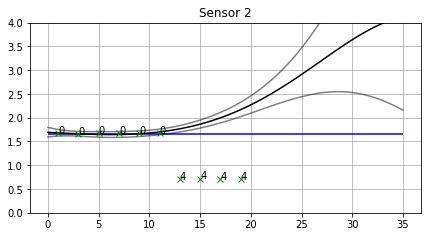

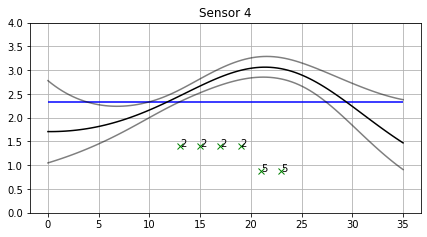

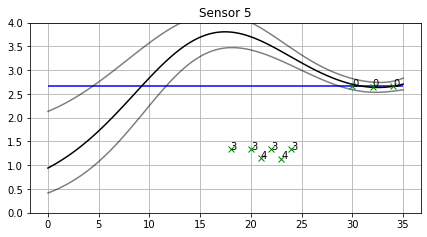

In [12]:
C = 1
Ttotal = 35
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,100)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[7,3.5])
    #plt.plot(x,1/(1+qf_mu[:,0]),'k-')
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-')
    #plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
    #r = (1/(1+(qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:])))).numpy()
    #r[r<0] = np.nan
    #plt.plot(x,r,'k-',alpha=0.5)
    #plt.plot(x,1/(1+(qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[0]/y[1],"%d" % x[2])
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg')
    for x,y in zip(X[senseX,:],Y[senseX,:]):
        plt.text(x[0],y[1]/y[0],"%d" % x[1])
    plt.hlines((3.0+si)/3.0,0,35,'b')
    plt.ylim([0,4])
    #plt.ylim([0.5,10])
    #plt.yscale('log')
    plt.grid()
    plt.title("Sensor %d"  % si)

False